# Anomaly Detection Evaluation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

## Sliding window size

In [2]:
filename = "all_features" #10min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_10 = pd.read_csv(filename, index_col=0)
B1_10.index = pd.to_datetime(B1_10.index)
B1_10_s = ad_pp.scale_robust(B1_10)

filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

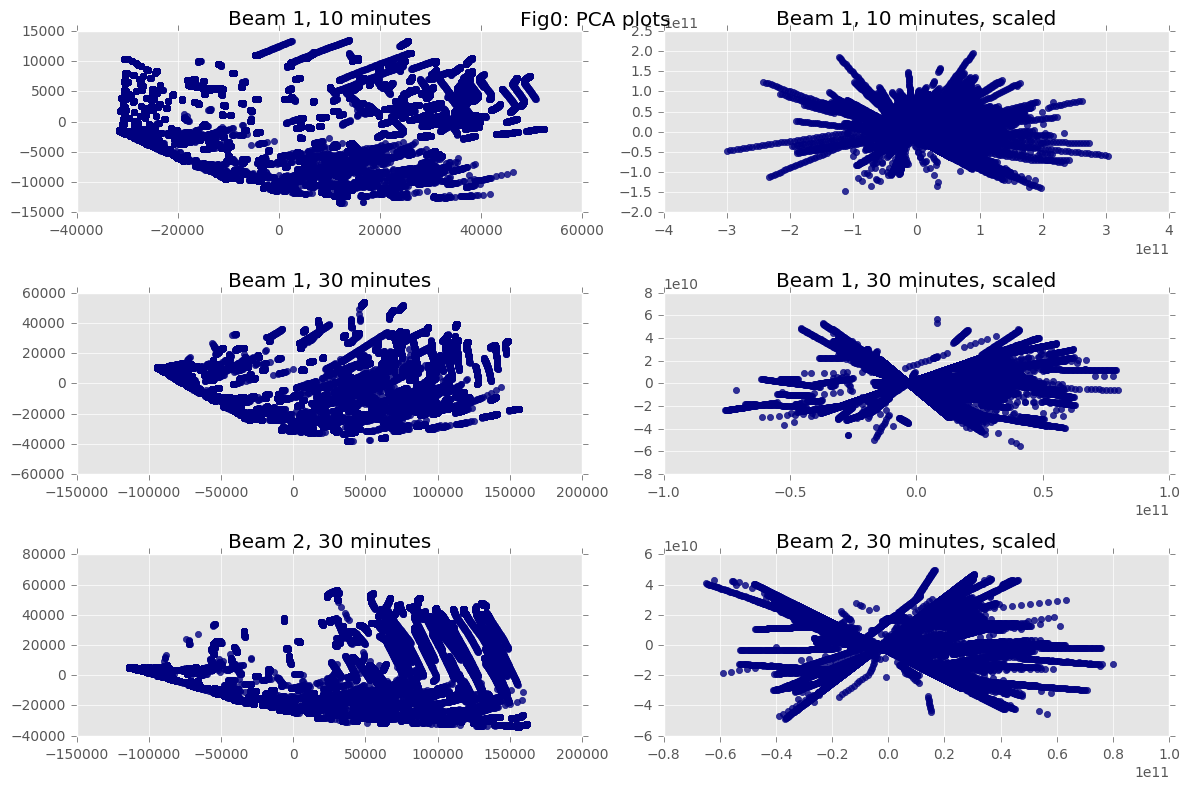

In [3]:
pca = PCA.create_pca(n_components=2)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
fig.suptitle("Fig0: PCA plots", fontsize="x-large")
plt.subplot(321)
B1_10_PCA = PCA.transform_data(B1_10, pca)
plt.scatter(B1_10_PCA[:, 0], B1_10_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 10 minutes")
plt.subplot(322)
B1_10_s_PCA = PCA.transform_data(B1_10_s, pca)
plt.scatter(B1_10_s_PCA[:, 0], B1_10_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 10 minutes, scaled")
plt.subplot(323)
B1_30_PCA = PCA.transform_data(B1_30, pca)
plt.scatter(B1_30_PCA[:, 0], B1_30_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 30 minutes")
plt.subplot(324)
B1_30_s_PCA = PCA.transform_data(B1_30_s, pca)
plt.scatter(B1_30_s_PCA[:, 0], B1_30_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 30 minutes, scaled")
plt.subplot(325)
B2_30_PCA = PCA.transform_data(B2_30, pca)
plt.scatter(B2_30_PCA[:, 0], B2_30_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 2, 30 minutes")
plt.subplot(326)
B2_30_s_PCA = PCA.transform_data(B2_30_s, pca)
plt.scatter(B2_30_s_PCA[:, 0], B2_30_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 2, 30 minutes, scaled")
plt.tight_layout()
plt.show()

Remarks:
* Difference between scaled and unscaled
* Big difference between 10 or 30 minute window
* Similar scaled versions for beam 1 & 2

## Model Selection

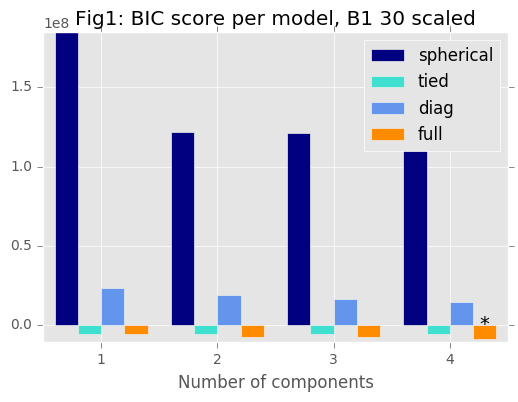

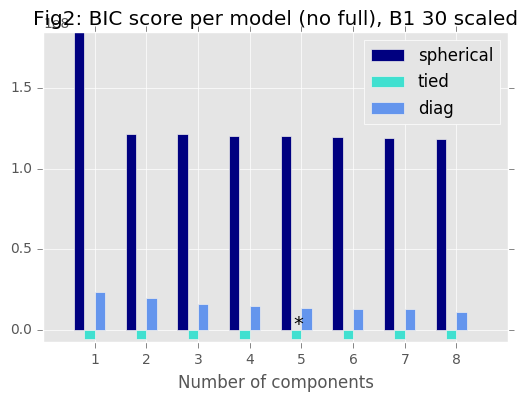

In [4]:
GMM.component_selection(B1_30_s, 'Fig1: BIC score per model, B1 30 scaled', 4)
GMM.component_selection(B1_30_s, 'Fig2: BIC score per model (no full), B1 30 scaled', cv_types=['spherical', 'tied', 'diag'])

In [5]:
clf = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf.fit(B1_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

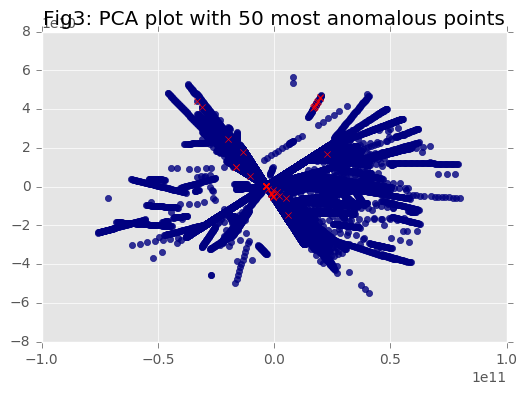

In [6]:
log_probs = clf.score_samples(B1_30_s)
top50 = GMM.get_top_N_anomalies(log_probs, 50)
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(B1_30_s, pca)
PCA.plot_anomalies(pca_data, top50, "Fig3: PCA plot with 50 most anomalous points")

## Evaluation (Beam 1)

In [7]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-09-14 00:00:00.000000'
labeled = client.query_tagged_anomalies(start_date, end_date)
detected = B1_30_s.iloc[top50.tolist()]
detected_sorted = detected.sort_index()

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


In [8]:
detected_w_label, labeled_w_detected = evaluation.compare_detected_w_labeled(detected_sorted, labeled)

In [9]:
display(detected_w_label)
total = sum(detected_w_label["has_label"])
pct = total/float(detected_w_label.shape[0]) * 100
display("Percentage with label: {0}".format(pct))

has_label
timestamps                   
2016-04-21 20:02:11     False
2016-04-21 20:09:40     False
2016-04-21 20:14:26     False
2016-04-25 22:57:31     False
2016-04-25 23:00:27     False
2016-04-25 23:02:25     False
2016-04-25 23:06:20     False
2016-04-25 23:08:17     False
2016-04-26 01:17:39     False
2016-04-26 01:27:27     False
2016-04-26 01:31:22     False
2016-04-26 01:33:20     False
2016-04-26 01:44:07     False
2016-05-30 05:47:52      True
2016-05-30 05:48:02      True
2016-06-01 10:05:49     False
2016-06-15 11:13:17     False
2016-06-19 12:50:40      True
2016-06-30 20:32:13      True
2016-07-31 01:26:37     False
2016-08-02 16:24:38      True
2016-08-02 17:28:14      True
2016-08-02 17:28:54      True
2016-08-02 17:29:14      True
2016-08-02 17:34:04      True
2016-08-02 17:34:14      True
2016-08-02 17:34:44      True
2016-08-02 18:55:01     False
2016-08-02 18:55:11     False
2016-08-02 18:55:21     False
2016-08-02 18:56:51     False
2016-08-02 18:57:31     False
2016-08-02 18:58:01     False
2016-08-02 19:00:51     False
2016-08-02 19:04:11     False
2016-08-02 19:04:31     False
2016-08-02 19:05:41     False
2016-08-02 19:06:01     False
2016-08-02 19:06:41     False
2016-08-02 19:07:21     False
2016-08-02 19:07:31     False
2016-08-02 19:07:41     False
2016-08-02 19:08:01     False
2016-08-29 18:17:25     False
2016-09-05 03:37:35     False
2016-09-06 12:40:52     False
2016-09-09 06:13:57     False
2016-09-10 07:11:13     False
2016-09-10 14:41:10     False
2016-09-11 19:26:04     False

'Percentage with label: 22.0'

Only 24% of all detected anomalies belong to a label. This is partially due to the detected timestamps on the 2nd of August: half of them are after the entry in the logbook.

In [10]:
display(labeled_w_detected)

nb_detected
timestamps                      
2016-05-30 14:00:00            2
2016-06-05 17:18:00            0
2016-06-18 19:59:00            0
2016-06-19 13:14:00            1
2016-06-30 21:23:00            1
2016-07-14 09:23:00            0
2016-07-24 22:19:48            0
2016-07-31 16:00:00            0
2016-08-02 17:28:00            1
2016-08-02 17:50:00            7
2016-08-03 08:05:00            0
2016-08-04 14:03:41            0
2016-08-21 20:00:00            0
2016-08-22 21:30:30            0
2016-08-23 06:53:47            0
2016-09-02 17:43:00            0

Most labeled anomalies have no corresponding detected timestamps.

### Clustering
Detected points can be clustered by using `cluster_detected`. The distance from a detected point to a cluster should be no more than 12 hours. The distance can be calculated with 4 methods:

* "start": distance to earliest timestamp in cluster
* "end": distance to latest timestamp in cluster
* "mean": distance to mean timestamp in cluster
* "edge": min distance to max or min timestamp in cluster

In [11]:
clusters = evaluation.cluster_detected(detected, method="mean")
display("Number of clusters: {0}".format(len(clusters)))
display("Average cluster length: {0}".format(np.mean([len(cluster) for cluster in clusters])))
for cluster in clusters:
    display(cluster.index.format(formatter=lambda x: x.strftime('%Y-%m-%d %H:%M.%S')))

'Number of clusters: 15'

'Average cluster length: 3.33333333333'

[u'2016-09-11 19:26.04']

[u'2016-08-02 19:00.51',
 u'2016-08-02 18:58.01',
 u'2016-08-02 18:57.31',
 u'2016-08-02 18:55.01',
 u'2016-08-02 17:34.44',
 u'2016-08-02 17:34.14',
 u'2016-08-02 17:34.04',
 u'2016-08-02 17:29.14',
 u'2016-08-02 17:28.54',
 u'2016-08-02 17:28.14',
 u'2016-08-02 19:04.11',
 u'2016-08-02 19:07.31',
 u'2016-08-02 19:07.21',
 u'2016-08-02 19:06.41',
 u'2016-08-02 18:55.11',
 u'2016-08-02 19:08.01',
 u'2016-08-02 16:24.38',
 u'2016-08-02 19:07.41',
 u'2016-08-02 19:06.01',
 u'2016-08-02 19:05.41',
 u'2016-08-02 18:56.51',
 u'2016-08-02 19:04.31',
 u'2016-08-02 18:55.21']

[u'2016-09-10 07:11.13', u'2016-09-10 14:41.10']

[u'2016-04-21 20:09.40', u'2016-04-21 20:14.26', u'2016-04-21 20:02.11']

[u'2016-09-09 06:13.57']

[u'2016-09-06 12:40.52']

[u'2016-07-31 01:26.37']

[u'2016-06-30 20:32.13']

[u'2016-06-19 12:50.40']

[u'2016-04-26 01:44.07',
 u'2016-04-26 01:33.20',
 u'2016-04-25 22:57.31',
 u'2016-04-25 23:00.27',
 u'2016-04-25 23:02.25',
 u'2016-04-25 23:06.20',
 u'2016-04-25 23:08.17',
 u'2016-04-26 01:31.22',
 u'2016-04-26 01:27.27',
 u'2016-04-26 01:17.39']

[u'2016-06-01 10:05.49']

[u'2016-05-30 05:47.52', u'2016-05-30 05:48.02']

[u'2016-09-05 03:37.35']

[u'2016-06-15 11:13.17']

[u'2016-08-29 18:17.25']

In [12]:
labeled_w_clusters = evaluation.compare_clustered_w_labeled(clusters, labeled, method="start")
display(labeled_w_clusters)

nb_detected  nb_clusters
timestamps                                   
2016-05-30 14:00:00            2            1
2016-06-05 17:18:00            0            0
2016-06-18 19:59:00            0            0
2016-06-19 13:14:00            1            1
2016-06-30 21:23:00            1            1
2016-07-14 09:23:00            0            0
2016-07-24 22:19:48            0            0
2016-07-31 16:00:00            0            0
2016-08-02 17:28:00           23            1
2016-08-02 17:50:00           23            1
2016-08-03 08:05:00            0            0
2016-08-04 14:03:41            0            0
2016-08-21 20:00:00            0            0
2016-08-22 21:30:30            0            0
2016-08-23 06:53:47            0            0
2016-09-02 17:43:00            0            0

### Beam 1 and 2
50 points leads to 15 clusters which is not a lot. The numer of points has to be increased.

In [13]:
clf_B1 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B2.fit(B2_30_s)
log_probs_B1 = clf_B1.score_samples(B1_30_s)
top1000_B1 = GMM.get_top_N_anomalies(log_probs_B1, 1000)
detected_B1 = B1_30_s.iloc[top1000_B1.tolist()]
log_probs_B2 = clf_B2.score_samples(B2_30_s)
top1000_B2 = GMM.get_top_N_anomalies(log_probs_B2, 1000)
detected_B2 = B2_30_s.iloc[top1000_B2.tolist()]

In [14]:
clusters_B1 = evaluation.cluster_detected(detected_B1, method="mean")
clusters_B2 = evaluation.cluster_detected(detected_B2, method="mean")
cluster_lengths_B1 = [len(cluster) for cluster in clusters_B1]
cluster_lenghts_B2 = [len(cluster) for cluster in clusters_B2]

display("Number of clusters for B1: {0}".format(len(clusters_B1)))
display("Min/mean/max cluster length for B1: {0}, {1}, {2}".format(min(cluster_lengths_B1), np.mean(cluster_lengths_B1), max(cluster_lengths_B1)))
display("Check: number of anomalies for B1: {0}".format(sum([len(cluster) for cluster in clusters_B1])))
display("Number of clusters for B2: {0}".format(len(clusters_B2)))
display("Min/mean/max cluster length for B2: {0}, {1}, {2}".format(min(cluster_lenghts_B2), np.mean(cluster_lenghts_B2), max(cluster_lenghts_B2)))
display("Check: number of anomalies for B2: {0}".format(sum([len(cluster) for cluster in clusters_B2])))

'Number of clusters for B1: 96'

'Min/mean/max cluster length for B1: 1, 10.4166666667, 175'

'Check: number of anomalies for B1: 1000'

'Number of clusters for B2: 126'

'Min/mean/max cluster length for B2: 1, 7.93650793651, 107'

'Check: number of anomalies for B2: 1000'

In [15]:
labeled_w_clusters_B1 = evaluation.compare_clustered_w_labeled(clusters_B1, labeled, method="start")
labeled_w_clusters_B1.rename(columns={"nb_detected": "nb_detected_B1", "nb_clusters": "nb_clusters_B1"}, inplace=True)
labeled_w_clusters_B2 = evaluation.compare_clustered_w_labeled(clusters_B2, labeled, method="start")
labeled_w_clusters_B2.rename(columns={"nb_detected": "nb_detected_B2", "nb_clusters": "nb_clusters_B2"}, inplace=True)
labeled_w_clusters_all = labeled_w_clusters_B1.join(labeled_w_clusters_B2)
display(labeled_w_clusters_all)

nb_detected_B1  nb_clusters_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               5               1               5   
2016-06-05 17:18:00               1               1               3   
2016-06-18 19:59:00               0               0               1   
2016-06-19 13:14:00              63               1               8   
2016-06-30 21:23:00             135               1             107   
2016-07-14 09:23:00               4               1               0   
2016-07-24 22:19:48               1               1              17   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             175               1               3   
2016-08-02 17:50:00             175               1               3   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               3   
2016-08-21 20:00:00               2               1              91   
2016-08-22 21:30:30               0               0               2   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_clusters_B2  
timestamps                           
2016-05-30 14:00:00               1  
2016-06-05 17:18:00               1  
2016-06-18 19:59:00               1  
2016-06-19 13:14:00               2  
2016-06-30 21:23:00               1  
2016-07-14 09:23:00               0  
2016-07-24 22:19:48               1  
2016-07-31 16:00:00               1  
2016-08-02 17:28:00               1  
2016-08-02 17:50:00               1  
2016-08-03 08:05:00               0  
2016-08-04 14:03:41               1  
2016-08-21 20:00:00               1  
2016-08-22 21:30:30               1  
2016-08-23 06:53:47               0  
2016-09-02 17:43:00               0

Model doesn't detect most points in the labeled set.

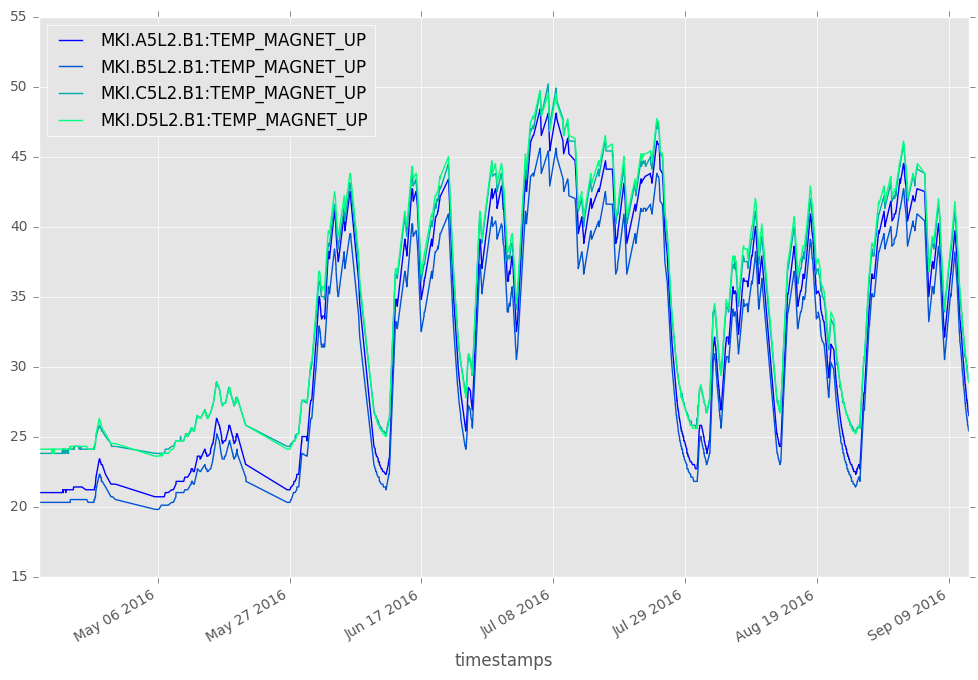

In [16]:
import re
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
regex = '^MKI.*:%s$' % "TEMP_MAGNET_UP"
timeseries = B1_30.filter(regex=regex)
timeseries.plot(ax=axes, colormap='winter', kind='line')

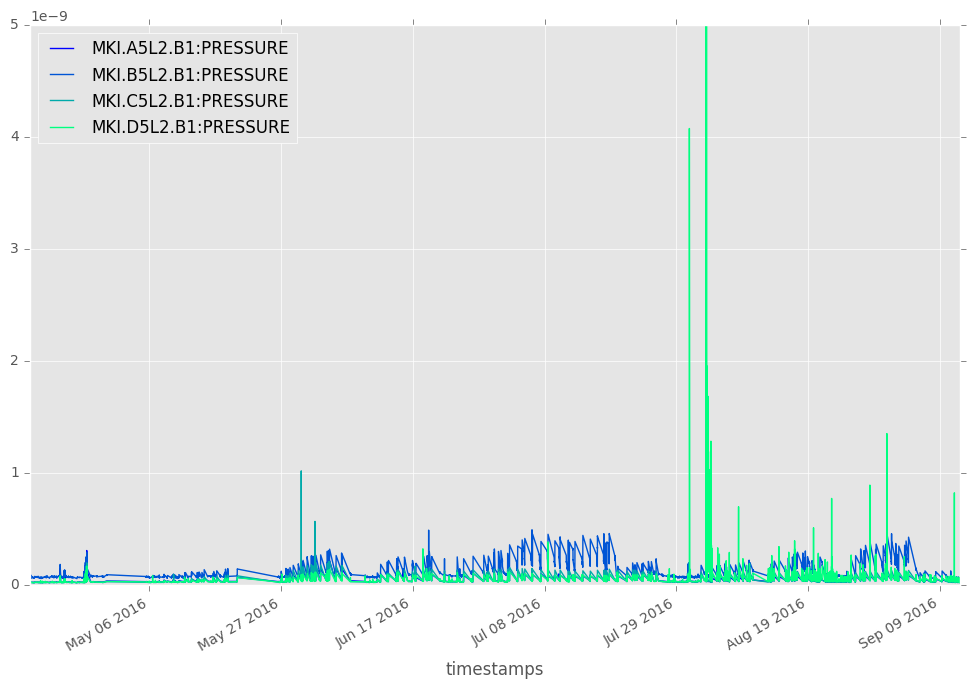

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
regex = '^MKI.*:%s$' % "PRESSURE"
timeseries = B1_30.filter(regex=regex)
timeseries.plot(ax=axes, colormap='winter', kind='line')

Adjust filters for pressure?